In [4]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
import jax.numpy as jnp
from jax import vmap, grad, jit
from jax import random

from gpx.models import GPR
from gpx.kernels import SquaredExponential
from gpx.parameters import Parameter
from gpx.priors import NormalPrior
from gpx.utils import softplus, inverse_softplus

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def _func(x):
    """Latent function."""
    return (
        1.0 * jnp.sin(x * 3 * jnp.pi)
        + 0.3 * jnp.cos(x * 9 * jnp.pi)
        + 0.5 * jnp.sin(x * 7 * jnp.pi)
    )


func = vmap(_func)
grad_func = vmap(grad(_func))

# Number of training examples
n = 50

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))
df = grad_func(X.reshape(-1))
dy = (
    grad_func(X.reshape(-1)).reshape(n, 1)
    + sigma_y
    + random.normal(random.PRNGKey(0), shape=(n, 1))
)

# Test data
X_test = jnp.linspace(-1.5, 1.5, 100).reshape(-1, 1)
f_true = func(X_test)
df_true = grad_func(X_test.reshape(-1)).reshape(100, 1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


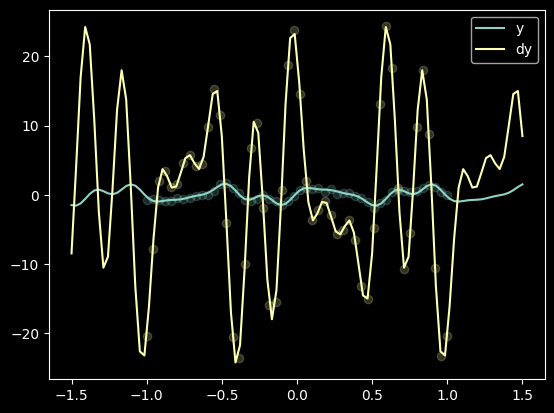

In [3]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X_test, f_true, label="y")

plt.scatter(X, df, alpha=0.2)
plt.plot(X_test, df_true, label="dy")

plt.legend()

In [5]:
kernel_params = {
    "lengthscale": Parameter(0.2, True, softplus, inverse_softplus, NormalPrior())
}
sigma = Parameter(1.0, True, softplus, inverse_softplus, NormalPrior())

kernel = SquaredExponential()

In [6]:
# we give the model the function computing the hessian kernel
model = GPR(kernel.d01k, kernel_params, sigma)
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬───────────────────────┬───────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ forward   │ backward         │ prior                 │ type      │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │     0.2 │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │     1   │
└────────────────────┴─────────────┴───────────┴──────────────────┴───────────────────────┴───────────┴─────────┴─────────┴─────────┘


In [7]:
model.fit(X, dy)

In [8]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬───────────────────────┬───────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ forward   │ backward         │ prior                 │ type      │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 0.134649 │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 0.949245 │
└────────────────────┴─────────────┴───────────┴──────────────────┴───────────────────────┴───────────┴─────────┴─────────┴──────────┘


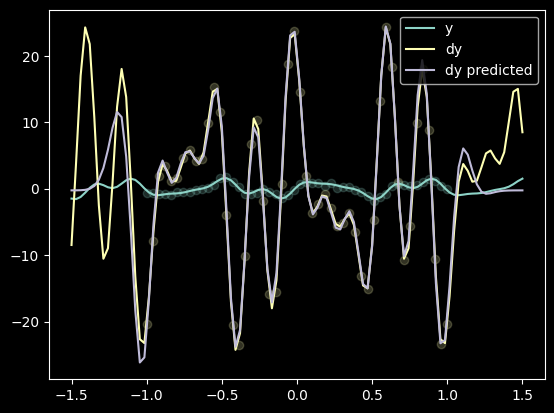

In [9]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X_test, f_true, label="y")

plt.scatter(X, df, alpha=0.2)
plt.plot(X_test, df_true, label="dy")

plt.plot(X_test, model.predict(X_test), label="dy predicted")

plt.legend()